In [1]:
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
import pingouin
import matplotlib.pyplot as plt

params_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'
bids_folder = '/Users/mrenke/data/ds-dnumrisk'
plot_folder = '/Users/mrenke/data/ds-dnumrisk/plots_and_ims/phenotype'


In [2]:
df_part = pd.read_csv(op.join('/Users/mrenke/data/ds-dnumrisk/add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
df_part = df_part.loc[:,['subject ID', 'age','group','gender']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
df_part['group'] = np.where(df_part['group'] == 0, 'control', 'dyscalc')

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
gammas = pd.read_csv(op.join(params_folder, f'gamma-magjudge_probit-startSimple2.csv'))
gammas.set_index('subject', inplace=True)

In [4]:
panamath_scores = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/panamath_AllRunsSummary.csv')
df_pana = panamath_scores.rename(mapper={'Subject ID': 'subject'}, axis=1).set_index('subject')[['Number of Trials','Weber Fraction', 'Percent Correct', 'Number of Non-RT-Outlier Trials']]
df_pana = df_pana.rename(mapper={'Weber Fraction': 'weber_frac'}, axis=1).drop(999, axis=0).sort_index()

math_stuff = pd.read_csv(op.join(params_folder, 'math_skill&confidence&anxiety-means.csv')).set_index('subject')

vs_wm = pd.read_csv(op.join(params_folder, 'visio-spatial-WM_CBTtask-params.csv'))
vs_wm.set_index('subject', inplace=True)

iq_scores = pd.read_csv(op.join(params_folder, 'iq-scores_ids2.csv')).set_index('subject')
#iq_scores['mean_iq_z'] = stats.zscore(iq_scores['mean_iq'])

In [5]:
model_label=1
format='both'
risk_params = pd.read_csv(op.join(params_folder,f'risk_all-params_probit-{model_label}_format-{format}.csv'))
risk_params = risk_params.set_index(['subject','format'])

format = 'non-symbolic'
df_risk = risk_params.xs(format,0,'format')

In [6]:
df_comb = gammas.join(df_pana['weber_frac']).join(iq_scores).join(df_part).join(vs_wm).join(df_risk['rnp']).join(math_stuff)   
df_comb['rnp_dev'] = np.abs((df_comb['rnp'] - 0.55))
df_comb.head()

,gamma,weber_frac,me,kn,mean_iq,age,group,gender,basisscore,overall_score,erfassungsspanne,rnp,skill_score,anx_mean,conf_mean,rnp_dev
subject,,,,,,,,,,,,,,,,
1,4.378226,0.143232,120.0,105.0,112.5,19.0,control,w,5,13.0,8,0.274486,36.0,1.333333,2.666667,0.275514
2,3.205958,0.119873,100.0,95.0,97.5,17.0,dyscalc,w,5,10.0,6,0.285983,6.0,2.666667,0.666667,0.264017
3,2.701954,0.349204,115.0,95.0,105.0,15.0,control,w,4,7.0,5,0.205277,29.0,1.666667,3.333333,0.344723
4,4.681309,0.183717,110.0,105.0,107.5,17.0,dyscalc,w,4,7.0,6,0.361833,34.0,4.000000,1.833333,0.188167
5,3.369357,0.154192,90.0,115.0,102.5,20.0,control,w,4,10.0,7,0.369147,30.0,2.000000,2.333333,0.180853


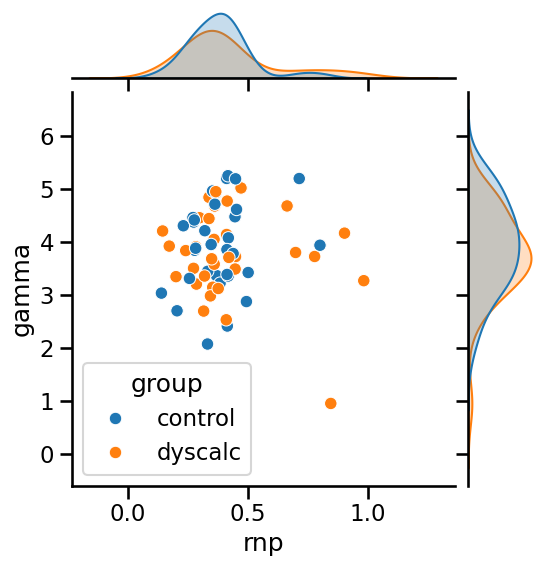

In [7]:
sns.set_context('talk')
ax = sns.jointplot(data=df_comb, x='rnp', y='gamma', hue='group') # ,kind='reg'

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=3)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set_context('talk')

In [9]:
df_comb.columns
var_list = ['me', 'kn','erfassungsspanne','skill_score','anx_mean', 'conf_mean']
name_list = ['Visuospatial reasoning', 'Verbal reasoning', 'Visuospatial working memory', 'Math skills', 'Math anxiety', 'Math confidence']
point_list = ['IQ points','IQ points','Corsi span', 'Test points','Anxiety rating', 'Confidence rating']

In [11]:
for i in range(len(var_list)):
    var = var_list[i]
    var_name = name_list[i]
    points = point_list[i]

    plt.figure(figsize=(3,2))
    #ax = sns.kdeplot(data=df_comb, x=var,hue='group',fill=True,legend=False)
    ax = sns.histplot(data=df_comb, x=var,hue='group',bins=10,legend=False)

    g0 = df_comb.loc[df_comb['group']=='control'][var]
    g1 = df_comb.loc[df_comb['group']=='dyscalc'][var]

    pval = np.round(pg.ttest(g0,g1)['p-val'].values[0], 4)

    ax.set_title(f'p={pval}', fontsize=12)
    if pval == 0.0000:
        ax.set_title(f'p<0.001', fontsize=12)
    ax.annotate(f'{var_name}', xy=(0.5, 1), xytext=(0, 25), 
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='baseline',fontweight='bold')
    ax.set(yticks=[]) # xlabel='IQ scores')
    ax.set_xlabel(points, fontsize=12) # IQ scores
    ax.set_ylabel('Density', fontsize=12) 

    sns.despine()
    plt.savefig(op.join(plot_folder,f'{var}_groups_hist.pdf'),bbox_inches='tight')
    plt.close()



/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_47219/2127100226.py:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax_legend.legend(legend.legendHandles, [t.get_text().capitalize() for t in legend.get_texts()], loc='center')


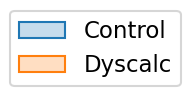

In [17]:
# make legend
var = var_list[0]
ax_temp = sns.kdeplot(data=df_comb, x=var, hue='group', fill=True, legend=True)
legend = ax_temp.get_legend()
plt.close()

plt.figure(figsize=(2, 1))  # Adjust the size as needed
ax_legend = plt.gca()
ax_legend.legend(legend.legendHandles, [t.get_text().capitalize() for t in legend.get_texts()], loc='center')
ax_legend.axis('off')
plt.savefig(op.join(plot_folder, 'legend.pdf'), bbox_inches='tight')

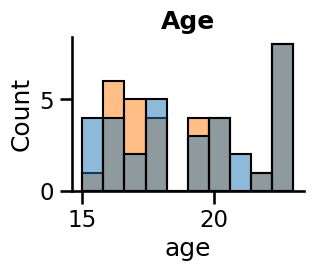

In [40]:
var = 'age'
var_name = 'Age'
plt.figure(figsize=(3,2))
ax = sns.histplot(data=df_comb, x=var,hue='group',bins=10,legend=False)
ax.set_title(f'{var_name}', fontsize=18,fontweight='bold')

sns.despine()   
plt.savefig(op.join(plot_folder,f'{var}_groups_hist.pdf'),bbox_inches='tight')

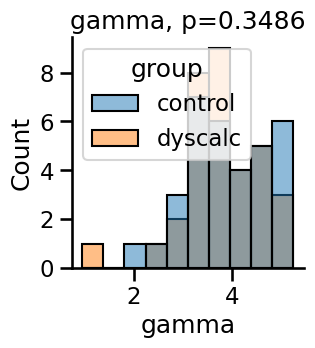

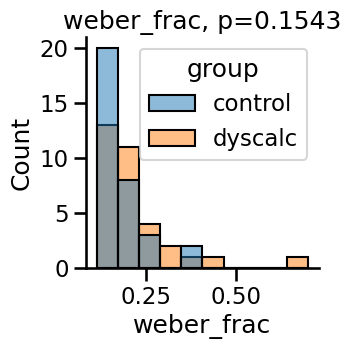

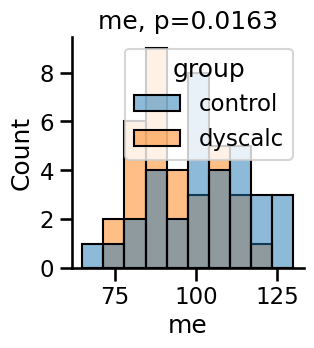

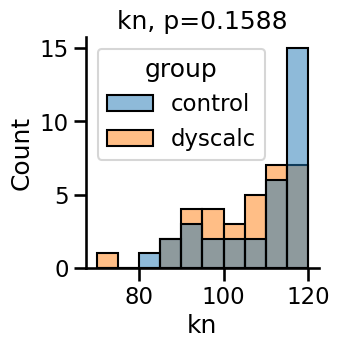

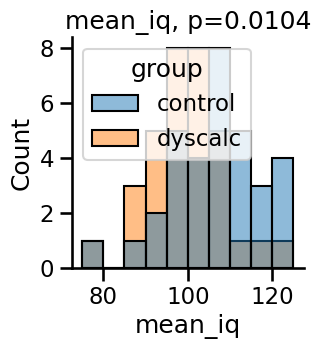

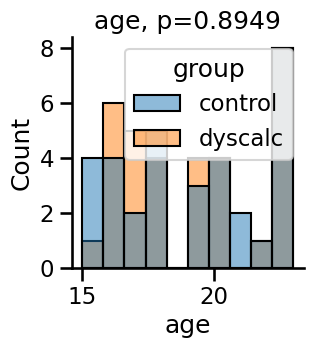

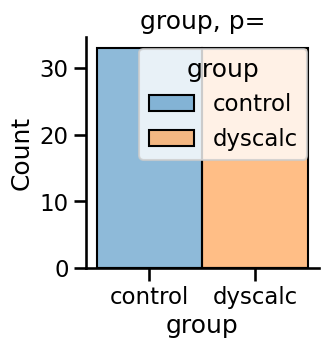

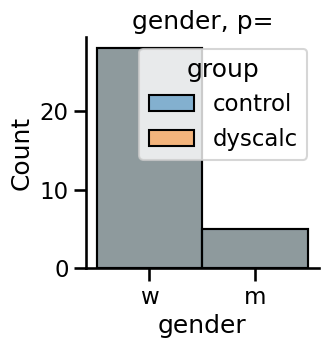

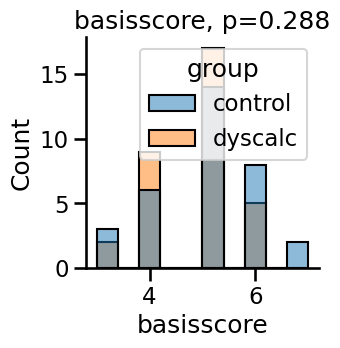

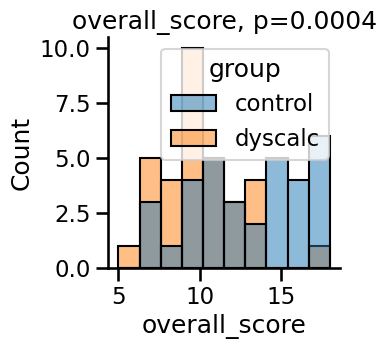

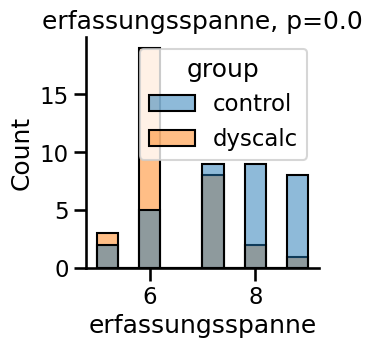

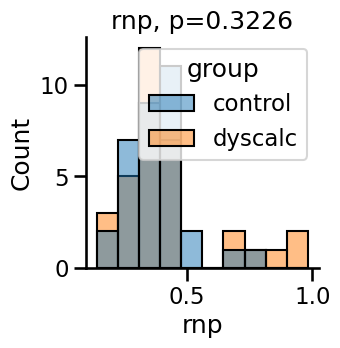

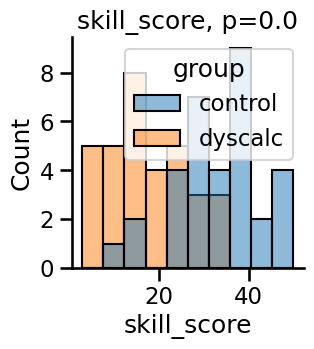

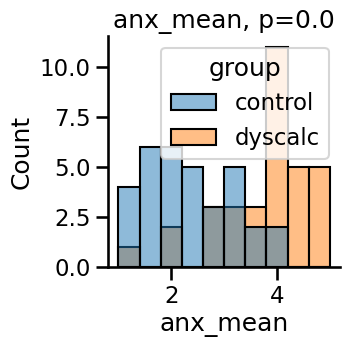

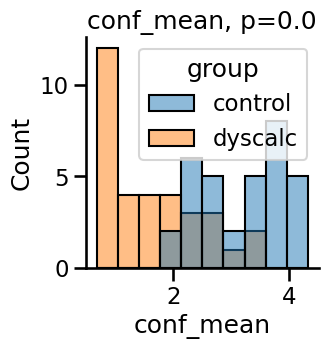

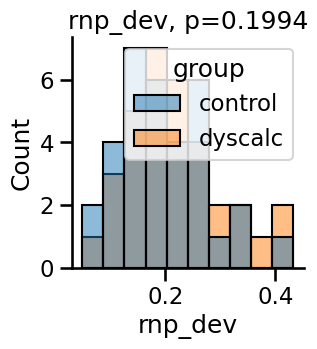

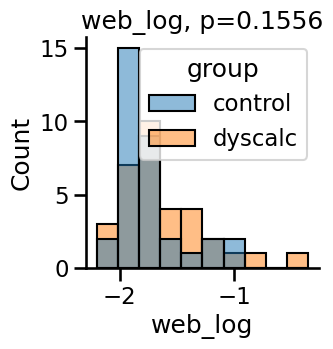

In [50]:


for var in df_comb.columns:
    plt.figure(figsize=(3,3))
    sns.histplot(data=df_comb, x=var,hue='group',bins=10)

    g0 = df_comb.loc[df_comb['group']=='control'][var]
    g1 = df_comb.loc[df_comb['group']=='dyscalc'][var]

    try: 
        pval = np.round(pg.ttest(g0,g1)['p-val'].values[0], 4)
    except:
        pval = ''
    plt.title(f'{var}, p={pval}')
    sns.despine()

In [49]:
df_comb['web_log'] = np.log(df_comb['weber_frac'])

In [36]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='rnp ~ gamma', data=df_comb.reset_index())
res = mod.fit()
#print(res.summary())

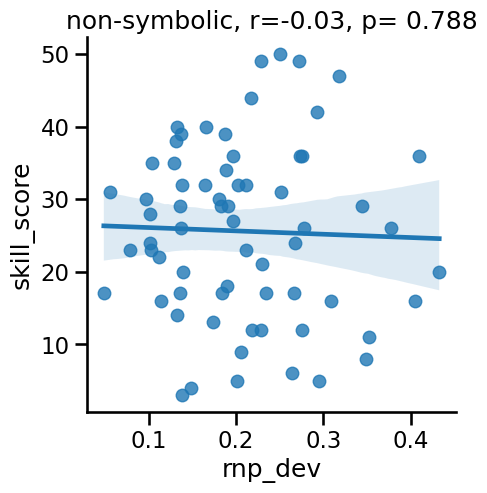

In [47]:
import pingouin as pg
sns.set_context('talk')
tmp = df_comb#.drop([46,49]) # outliers: df_comb['weber_frac'].idxmax(); df_comb['gamma'].idxmin()

y_var = 'skill_score' #'skill_score' # '4c' # 4b' #
x_var = 'rnp_dev'#'gamma_nonsymbolic' # 'conf_mean'

cor = pingouin.corr(tmp[y_var], tmp[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=tmp) #, hue='group'
fig.set(title=f'{format}, r={r_}, p= {p}') 


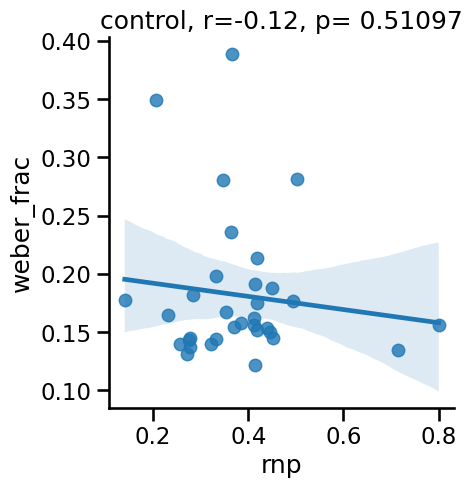

In [35]:
group = 'control' # 'dyscalc' # 
tmp = df_comb[df_comb['group'] == group]

cor = pingouin.corr(tmp[y_var], tmp[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=tmp) #, hue='group'
fig.set(title=fr'{group}, r={r_}, p= {p}') 
